# A/B testing & Hypothesis Testing 

**Contents**
- [Basic Concepts (with an virtual example)](#01)
    - [0. Background](#02)
    - [1. Prerequisites](#03)
        - 1).Objectives
        - 2).Metrics
        - 3).Variants
        - 4).Randomization Units  
    - [2. Experiment Design](#04)
        - 1).Target Population 
        - 2).Sample Size 
        - 3).Determine Test Duration
    - [3. Running Experiment](#05)    
    - [4. Result Analysis to Decision & Post-launch Monitoring ](#06) 
        - 1).Sanity check 
        - 2).Hypothesis Tests
        - 3).Statistical and Practical Significance
    - [5. Common Problems and Pitfalls](#07)  
        - 1).Multiple Testing Problems 
        - 2).Lack of Testing Power
        - 3).Changes in Users’ Behaviors
        - 4).Network Effects
- [Demo using Marketing A/B testing dataset](#08)
    - [About Dataset](#09)
    - [Working Process](#10)
        1. Understanding business problem & data
        2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value
        3. Look summary stats and plots
        4. Apply hypothesis testing and check assumptions
        5. Check Normality & Homogeneity
        6. Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
        7. Evaluate the results
        8. Make inferences
        9. Recommend business decision to your customer/director/ceo etc.

<a name="01"></a>
## Basic Concepts (with an virtual example)
**Note: The words that are quoted are all steps of examples**
<a name="02"></a>
### 0. Background : 
> We want to use A/B testing to test the effect of new feature "similar products" on the website checkout page for an e-commerce webpage.
There are two probable results of showing "similar products" on the website checkout page : 
>1. It may increase revenue by making customers to purchase other similar products
>2. Similar products may be cheaper /of more features/ more appealing to customers, so those products may distract customers that they may spend extra time exploring those products, which may result in delaying or abandoning checkout process. 

<a name="03"></a>
### 1. Prerequisites : 
#### 1). Objectives : Make sure we understand the objective of A/B testing 
>The A/B testing aims to test the effect of new "similar products" feature at the website checkout page for a e-commerce retailer. 

#### 2). Metrics
> **Ideal metrics for this experiment:**
>- Difference in revenue due to the new feature of "similar products" 
>- Revenue (when there are equal numbers of customers in treatment group and control group)
>- Revenue per user (when there are different numbers of customers in treatment group and control group)

**Experiment Metrics Criteria** :
- **Measurable within the experiment timeframe.**
- **Attributable to the change in the product/feature.**
- **Sensitive enough to detect changes that matter in a timely fashion.**

1. **Success Metrics (goal metrics, true north metrics)**
- A single or a very small set of metrics that capture the ultimate success you are striving towards
- Reflects company's vision & mission 
- Easily understood and broadly accepted by stakeholders
- Stable over time (should not be necessary to update goal metrics every time you launch a new feature)
- May not be suitable for experiments 
    - difficult to measure 
    - not sensitive to product changes

2. **Driver Metrics (signpost metrics, surrogate metrics, indirect or predictive metrics)**
- Shorter-term, faster-moving
- Reflects hypotheses on the drivers of success and indicates we are moving in the right direction to move the goal metrics
- Resistant to gaming (when experiment shows result but there is not meaningful insight)
- **Sensitive & Timely** : sensitive enough to the change made in the business
    - Good example : CTR (click through rate)/conversion rate (% of users take the desired action )
        - Immediately reflect ads performance
    - Bad example : DAU 
        - Takes time for users to purchase, adopt to the product 
        - Important to the business but not suitable for A/B testing
- **Measurable :** able to calculate metrics with data collected during experiment period.
    - Good example : CTR (click through rate)
        - Counts can be obtained real time
    - Bad example : MAU/retention
        - Out of the experiment time frame
- **Attributable :** Able to attribute the change in metrics to experiment variants;able to measure the metrics in both treatment and control groups
    - Good example : CTR (click through rate)
        - Attribute CTR to the ads design
    - Bad example : DAU/ user retention
        - Many other things can cause the change
- How to generate driver metrics:
    - Combine quantitative and qualitative methods
        - qualitative : user experience research, focus groups, and surveys to understand users' needs
        - quantitative : data analysis, such as analysis of logs to see what users do and find patterns in logs
    - Business goals: growth, engagement, revenue
    - HEART: happiness, engagement, adoption, retention, and task Success
    - AARRR: acquisition, activation, retention, referral, and revenue
    - User funnel : consider the steps users in each group need to take to use a feature or a product as most products have a funnel that moves users towards taking key actions or desired outcomes that are meaningful to the business
    
<img style="float: middle;" src='user funnel.png' width="50%">         

3. **Guardrail Metrics (counter metrics)**: guard new feature from harming the business or violating assumptions
- Organizational Guardrails
    - Ensures we move towards success with the right balance and without violating important constraints
    - E.g. 
        - Website/App performance
        - latency: wait times for pages to load
        - error logs: number of error messages
        - client crashes: number of crashes per user
        - business goals
        - revenue: revenue per user and total revenue
        - engagement (e.g. time spent per user, DAU, and page views per user)

- Trust-related guardrails
    - Assess the trustworthiness and internal validity (whether violate any assumptions)of experiment results
    - E.g. 
        - the Sample Ratio Mismatch (SRM) guardrail and cache hit ratio to be the same among Control and Treatment.

**How to make a decision when on metric goes up and one metric goes down ?**
- We can make Overall Evaluation Criterion (OEC) to build up mental model of the trade-offs
    - eg. user acquisition & revenue (expensive campaigns degrade revenue)
    - decisions are made among many stakeholders
    - we can have a weighted combination of different metrics
    
- If it's difficult for us to have such OEC, we can have no more than 5 metrics, as too many metrics :
    - will cause confusion & easily ignore the key metrics
    - increase chances of false discovery 

#### 3). Variants : Control Group and Treatment Group
> Control Group and Treatment Group setup
>- Control group : checkout page without showing any similar products
>- Treatment group I : adding a "similar product" section on the checkout page 
>- Treatment group II : adding a "similar product" pop-up window on the checkout page 

#### 4). Randomization Units : who / what we randomly assign to each variant of an A/B testing

**Common Types :**

1. **Account-Based/User-Based(User ID/login)**: every single account is a randomization unit. 
    - pros: 
        - stable across time and platforms
        - allow for long-term measurement
    - cons: 
        - mindful of identifiable
        - requires to login to dentify
2. **Cookie-Based(Cookies)**: a pseudonymous user ID, that is specific to a browser and a device
    - pros : 
        - used to identify users without logging 
        - anonymous
    - cons : 
        - users can clear cookies
        - not persistent across platforms
3. **Event-Based(Session-Based/Page View-Based)**: Every user session is a randomization unit. A session starts when a user logs in and ends when a user logs out or after 30 min of inactivity; Every page visit is a randomization unit. It does not require users to log in and does not distinguish between users.  
    - pros : 
        - finer level of granularity creates more units (one user can be connected to many page views or session)
        - provides more units and gives more power to detect small changes
    - cons : 
        - only appropriate when changes are not visible to the user
        - may lead to an inconsistent user experience 

4. **Device-Based**: Every Device ID is a randomization unit
    - pros : immutable ID associated with a specific device
    - cons : 
        - identifiable
        - only available for mobile devices
        
5. **IP-Based**: Every IP address is a randomization unit. Every device in every network is assigned a unique IP
    - pros : maybe the only option for certain experiments (e.g. testing latency using one hosting service versus another)
    - cons : 
        - Inconsistent user experience : changes when users change places
        - Many users share the same IP address
       
**General Considerations:**
1. Consistent user experience 
- For changes **visible to users**, we should use a **user ID or a cookie** as the randomization unit.
- For changes **invisible to users**, e.g., change in latency, it depends on what we want to measure. A user ID or a cookie are still good options if we want to see what happens over time.

2. Variability 
- If the **randomization unit is the same as the unit of analysis**, the empirically computed variability is similar to the analytically computed variability.
- If the **randomization unit is coarser than the unit of analysis**, e.g., the randomization unit is the user and we wish to analyze the click-through rate (the unit of analysis is a page view), the variability of the metric will be much higher. This is because the independence assumption is invalid as we are dividing groups of correlated units, which increases the variability.

3. Ethical considerations 
- May face security and confidentiality issues when using identifiable randomization units.

<a name="04"></a>
### 2. Experiment Design
#### 1). Target Population
Consider geographic region, platform (mobile vs tablet vs laptop), device type, user demographics (age, gender, country, etc), usage or engagement level (analyze the user journey, example), etc
E.g. A new feature only available for users in a particular geographic region → Only need toselect users in that region
>User journey : Consider only those customers who intend to make purchase and initiate checkout page because they can check the new "similar products" feature
> <img style="float: middle;" src='user f.png' width="50%">         

#### 2). Sample Size
Two-sampled t-tests are the most common statistical significance tests used. Suppose Y is a metric of interest.
- $H_0$: mean($Y_t$)= mean($Y_c$) (no treatment effect)
- $H_a$: mean($Y_t$)$\neq$ mean($Y_c$) (there is a treatment effect)

The required sample size depends on 4 things:

1. **Significance level: $\alpha$ (common choice is .05):** <br>
$\alpha$ = Type I Error 
         = when the null hypothesis is actually true, rejecting the null hypothesis 
         = incorrectly rejecting the null hypothesis 
         = False Positive 
Significance level: The probability that we reject even when the treatment has no effect. The probability of committing a Type I error ($\alpha$). <br>

2. **Statistical power: $1-P(\beta)$ (common choice is .8):**<br>
$\beta$ = Type II Error
        = when the alternative hypothesis is true, failing to reject the null hypothesis 
        = incorrectly accepting the null hypothesis = False Negative 
Statistical power: <br>
    - The probability that we reject when the treatment indeed has an effect. 
    - This measures how sensitive the experiment is. 
    - If power is too low, we can’t detect true effects; 
    - if it’s unrealistically high (.99), we may never finish the experiment. <br>

3. **Variances: $\sigma^2$**
    - Because samples are independent, $Var(\triangle) = Var(E[Y_t]) + Var(E[Y_c])$ where $\triangle$ is the difference between the Treatment average and the Control average. 
    - Variances are often estimated either from historical data or from A/A tests.

4. Minimally detectable effect (MDE) $\delta$(a.k.a. practical significance):
The smallest difference that matters in practice

**Sample Size Formula** <br>

$n = \frac{(\sigma_t^2 + \sigma_c^2) (z_{1-\alpha/2} + z_{1-\beta})}{\delta^2}$ 

**Proof :**

Based on central limit theorem : $\bar{x} \sim N (\mu_c - \mu_t, \frac{2\sigma^2}{n})$ assuming that 2 populations have the same variance. 

We can transform to standard normal distribution, $Z = \frac{\bar{x} - (\mu_c - \mu_t)}{\frac{\sqrt{2}\sigma}{\sqrt{n}}} \sim N(0,1)$. 

Type II error rate $(\beta)$: P (accepting $H_0$ when difference exists), $\beta$= P(acceptance of $H_0$)

<img style="float: left;" src='function.png' width="48%">         

<img style="float: right;" src='f2.png' width="48%">         

As typically, we choose $\alpha$=0.05, then $z_{1-\alpha/2} = z_.975 \approx 1.96$ ; and $\beta = 0.2$, then $z_{1-\beta} = z_.80 \approx 0.84$. Assuming that treatment group and control group are of equal size, the required sample size for each variant is about : $\frac{16\sigma^2}{\delta^2}$

- $\sigma^2$ : Sample variance of the difference between the treatment group and control group. We can estimate it from the historical data. 
- $\delta$ : Practical significance (Minimum detectable effect), determind among multiple stakeholders. How much change is the change that matters from the business perspective given all the costs associated with making a change. 
> For this example , how much increase in revenue  per user  will be considered to outweigh the cost. Assume different stakeholders have agreed on revenue increase of $2/user is practically significant.

#### 3). Test Duration
**Test Duration :** $\frac{\text{Sample Size}}{\text{Randomization Units/Day}} $
- Pitfalls:
    - Avoid a duration of less than a week.
    - A longer test gathers more data and is almost always better.

##### i. Ramp-up plan: trade-off among speed, quality, risk (SQR)

>In A/B testing, a ramp-up plan is a strategy for gradually increasing the proportion of users who are exposed to a new experimental variation (e.g., a different version of a web page or app) over time. This helps to minimize the potential impact of any unexpected negative effects of the new variation on user behavior or performance metrics.


1. **mitigate risk (0-5%)**: Start with team members, company employees, loyal users, etc. in fear of bugs or other risks — these people tend to be more forgiving.
2. **maximum power ramp (MPR, 5-50%)**: Measure treatment effect.
3. **post-MPR (optional)**: Ensure infra can withstand the change.
4. **long-term holdout (optional)**: Be aware of opportunity costs and ethics because those users won't enjoy new features for a while.
5. No bug
6. Traffic can be handled without introducing too much latency 
7. Expose to small population 
8. Gradually increase percentage 
9. Role of thumb : start with dozens of users  


>Assume there are 200 users per day entering checkout <br>
<img style="float: left;" src='rp01.png' width="48%">  <img style="float: right;" src='rp02.png' width="48%">  

##### ii. Day of week effect : People behave differently on certain day of a week than other days (more purchases on weekends( 
-> so it’s recommended to run experiment for >= 1 whole week to capture this  effect 
 
##### iii. Seasonality : holiday season : surge in sales during Black Fridays  
-> Therefore, data used during holidays cannot be used for analysis ; then we need to run experiment longer 

##### iiii. Primacy and novelty effects: Users respond to changed differently  
-> Can run experiment longer when there is novelty or primacy effect but if we run experiment too long,  we will hit a diminishing return, the precision of the result won’t be improved any further  

<a name="05"></a>
### 3. Running Experiment
<a name="06"></a>
### 4. Result Analysis to Decision & Post-launch Monitoring 
#### 1). Sanity check :
##### Guardrail Metrics
1. Trust-related guardrail metrics help us ensure our assumptions regarding the data are not violated.
    - **Sample Ratio Mismatch (SRM)**. For the study population, we want 50% in the treatment and 50% in the control. 
    - Cache hit ratio to be the same among Control and Treatment.
    > **Cache hit ratio** in A/B testing refers to the proportion of users who see a cached version of the original or variation page rather than a newly generated version. Caching is a process where a copy of a web page or app is stored in memory or on disk to speed up page load times. <br>
    In the context of A/B testing, when a user visits a page that is being tested, the testing tool checks if there is a cached version of the page available. If there is a cached version available, the tool may decide to show the user the cached version rather than generating a new version of the page. This can help to reduce server load and improve page load times. <br>
    The cache hit ratio is the percentage of users who are served the cached version of the original or variation page. A high cache hit ratio indicates that the caching system is working well and is helping to improve page load times for users. However, a high cache hit ratio can also make it difficult to measure the impact of the A/B test accurately, as users may be seeing an outdated version of the page. <br>
    To ensure that A/B testing results are accurate, it's important to monitor the cache hit ratio and take it into account when interpreting the results of the test. This may involve excluding cached pageviews from the analysis or adjusting the sample size to account for the impact of caching. <br>
    - Test statistics follow the assumed distribution
        - When the sample size is big enough, by the central limit theorem (CLT), the sampling distribution of $\mu_t -\mu_c$ should be normally distributed.
        - Normality test

2. Organizational-related guardrail metrics are used to ensure that the performance of the organization is following the standard we expect.
    - Website/App performance
    - Latency: wait times for pages to load.
    - Error Logs: number of error messages.
    - Client Crashes: crashes per user.
    - Business goals
    - Revenue: revenue per user and total revenue.
    - Engagement: e.g., time spent per user, daily active users (DAU), and page views per user.

##### How To Do Sanity Checks
- A/A test: Sanity check of the A/B testing system. Run before the system is used in the application
    > An A/A test is a type of experiment in which **the same version of a webpage or application is shown to two groups of users, and the groups are compared to check if there are any statistically significant differences in their behavior or other metrics.** <br>
    In an A/A test, the two groups are randomly selected from the same population, and both groups are exposed to the exact same version of the webpage or application. The purpose of conducting an A/A test is to check whether the A/B testing tool being used is working correctly and that the statistical analysis being performed on the data is accurate. <br>
    If the A/A test shows that there is no statistically significant difference between the two groups, then it can be concluded that the A/B testing tool is functioning correctly and that any differences observed in future A/B tests are likely to be genuine. <br>
- Z-test or T-test: Both tests can be used to compare proportions or group means and test for significant differences between them.
    - Example: checking sample sizes between groups using Z-test
    - Note: In step 1, the "standard deviation" is the standard deviation of the sampling distribution for the proportion, or standard error (SE). SE should be used in computations instead of SD.
- Chi-Squared Test
    - Example: checking for the SRM. Using the Chi-squared test as a goodness of fit test, it is analogous to testing if the treatment/control assignment mechanism is a fair game (should be 50/50).

##### What If Sanity Checks Fail?
- Stop and assess. Ask what went wrong and how we can address it.
- These failures should be a priority concern before moving on to analyzing the data. Is this just a one-time issue or if it will persist or become worse over time? These are supposed to be invariant metrics; we do not want these to differ between groups. 
- We can also rerun the experiment.
- How to debug SRM 
    - Check Gap upstream of the randomization point
    - Check Variant assignment
    - Check Data processing pipeline 
    - Check Segments of population

#### 2). Hypothesis Tests
- If test statistics follow or can be approximated by normal or t-distributions, use the Z-test or t-test.
    - Z-test or t-test 
        - Decide one-tailed or two-tailed tests
        - Compute the mean 
        - Compute either pooled or unpooled variance
    - P-value
        - Definition: If $H_0$ is true, what's the probability of seeing an outcome (e.g., a t-statistic) at least this extreme?
        - How to use: If the p-value is below your threshold of significance (typically 0.05), then you can reject the null hypothesis.
        - Misconception: It's not the probability of $H_a$ being true.
    - Assumptions
        - Normality: When the sample size is big enough, by the central limit theorem (CLT), the sampling distribution of the difference in the means between the two groups should be normally distributed.
            - If the sample isn't large enough for the sampling distribution to be normal
                - solution #1: cap values if data is highly skewed
                - solution #2: use bootstrapping to calculate statistics
        - Independence: Each observation of the dependent variable is independent of other observations.
- Otherwise, use non-parametric tests.

#### 3). Statistical and Practical Significance
The graph shows 4 patterns of A/B testing results in terms of statistical and practical significance.

<img style="float: middle;" src='ci.png' width="60%"> 

1. Statistically and practically significant: The result is both statistically (p < 0.05 and 95% CI does not contain 0) and practically significant, so we should obviously launch it. → Launch!
2. Not practically significant:
    - Scenario 1: The change is **neither statistically (95% CI contains 0) nor practically significant** 
        - (95% CI sits in the middle), so not worth launching. 
        - → The change does not do much. 
        - Either decide to iterate or abandon this idea.
    - Scenario 2: **Statistically significant but not practically significant**
        - (95% CI doesn’t contain 0) 
        - → if implementing a new algorithm is costly, then it’s probably not worth launching; 
        - if the cost is low, then it doesn’t hurt to launch.
3. Likely statistically/practically significant:
    - Scenario 1: The 95% CI contains 0 and the CI is outside of what is practically significant. 
        - → There is not enough power to draw a strong conclusion and we do not have enough data to make any launch decision. 
        - Run a follow-up test with more units, providing greater statistical power.
    - Scenario 2: Likely practically significant. Even though our best guess (i.e., point estimate) is larger than the practical significance boundary, it’s also possible that there is no impact at all. 
        - → Repeat this test but with greater power to gain more precision in the result. <br>
   
   Both scenarios suggest our experiment may be underpowered, so we should probably run new experiments with more units if time and resources allow.<br>

4. Statistically significant and likely practically significant. 
    - It is possible that the change is not practically significant. → Can repeat the test with more power. 
    - However, choosing to launch is a reasonable decision.

<a name="07"></a>
### 5. Common Problems and Pitfalls

- 1). Multiple Testing Problems arise in the two scenarios below.
    1. **Problem #1 : Multiple success metrics (Multiple hypotheses)**--When the significance level (false positive probability) is 5% for each metric. With N metrics, Pr(at least one metric is false positive) = $1-(1-0.05)^N$ is much greater than 5%.
        - Solution: To address this, it's important to group the metrics into categories based on their expected impact, and use different significance levels for each category.
        
    2. **Problem #2 : Post-experiment result segmentation**--Multiple hypotheses are squeezed into one experiment. Also a higher chance of false positive results. The overall result can contradict segmented results (Simpson's Paradox).
    >**Simpson's Paradox** is a phenomenon that can occur in A/B testing (and in other statistical analyses) when **a trend appears in different groups of data, but disappears or reverses when the groups are combined.** This can lead to misleading or contradictory results, and can make it difficult to draw accurate conclusions from the data. <br>
    >**For example, imagine an A/B test where the overall conversion rate for Group A is higher than for Group B. However, when the data is segmented by another factor, such as age or gender, it is revealed that Group B actually has a higher conversion rate within each segment. This could happen if the groups have different proportions of users in each segment, and the segments themselves have different conversion rates. When the data is combined, the overall trend is obscured by the differences between the segments.**<br>
    Simpson's Paradox can be particularly problematic in A/B testing, where the goal is often to identify the impact of a single variable (such as a design change) on a specific metric (such as conversion rate). To avoid Simpson's Paradox in A/B testing, **it's important to carefully consider the variables and segments being tested, and to analyze the data at both the group and segment levels. It may also be necessary to run separate experiments for different segments, rather than trying to combine them into a single test.**<br>

        - Solution #1: Conduct separate experiments for each hypothesis
        - Solution #2: Avoid post-test result segmentation. 
        - Solution #3: If post-test result segmentation is desired:
            - Ensure enough randomization units in each segment
            - Ensure sufficient randomization in each segment

- 2). Lack of Testing Power
    - Causes
        - P-hacking: Stop the experiment earlier than the designed duration when observing the p-value is lower than the threshold value.
        > **P-hacking**, also known as data dredging or data snooping, is a practice that can occur in A/B testing (and in other statistical analyses) where **data is manipulated or analyzed in ways that increase the likelihood of finding a statistically significant result, even if the result is not truly meaningful or accurate**. <br>
        P-hacking can take many forms, such as *changing the significance level after the data has been collected, selecting only certain metrics that show a significant difference between groups, or running multiple tests until a significant result is found.*<br>
        One common form of p-hacking is called "peeking", where an analyst checks the results of a test before deciding when to stop the test. If the test shows a statistically significant result early on, the analyst may end the test prematurely, rather than continuing to collect data until a more accurate result can be obtained.<br>
        P-hacking can be a serious problem in A/B testing, as it can lead to false positive results and inaccurate conclusions. To avoid p-hacking, it's important to set a clear plan for the analysis before the test begins, and to stick to that plan without making changes based on the results. It's also important to use a pre-defined significance level, and to avoid making multiple comparisons or tests without adjusting the significance level accordingly.<br>
        - The experiment ran as designed but there are not enough randomization units.
        - High variance : Variance refers to the variability or spread of data points in a sample or population. High variance in an experiment can occur when there is a large amount of variability between the individual units or subjects in the groups being compared. This can make it difficult to detect a significant difference between the groups, even if there is a true effect. High variance can be addressed by increasing the sample size or by controlling for variables that may be contributing to the variability.
    - Solutions
        - Do not stop the experiment before the design's duration.
        - If there are not enough randomization units
            - If the experiment is still running, we should run the experiment until enough units are collected.
            - If not, we should re-run the experiment
        - Clean data to reduce variance: remove outliers (e.g., capping), log transformation (don't log transform revenue!)
        - Use trigger analysis, i.e., only include impacted units (e.g. conversion rate may be 0.5% when you include users from the top funnel but it may be 50% right before the change). The caveat is when generalizing to all users, true effect could be anywhere between 0 and the observed effect.

- 3). Changes in Users’ Behaviors
    - Causes 
        - Novelty and primacy effect
        - Seasonality
        - Market change
    - Solutions
        - Long-term monitoring
- 4). Network Effects
    - Use isolation methods. Ensure little or no spillover between the control and treatment units
    - Cluster-based randomization
        - Randomize based on groups of people who are more likely to interact with fellow groupmembers, rather than outsiders
    - Geo-based randomization
        - Limit control/treatment group to a specific location or a city
    - Time-based randomization
        - Select a random time and place all users in either control or treatment groups for a short period of time.
    - How to detect interference:
        - Monitor during the experiment
    - Long-term monitoring by allowing an experiment to run for at least 3 months or by having a holdback group, namely a small control group that is never given access to a new feature.

<a name="08"></a>
## Demo using Marketing A/B testing dataset
<a name="09"></a>
### About Data set 
Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they tun A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

The companies are interested in answering two questions:
- Would the campaign be successful?
- If the campaign was successful, how much of that success could be attributed to the ads?

With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

Data dictionary:

- Index: Row index
- user id: User ID (unique)
- test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
- converted: If a person bought the product then True, else is False
- total ads: Amount of ads seen by person
- most ads day: Day that the person saw the biggest amount of ads
- most ads hour: Hour of day that the person saw the biggest amount of ads

Link : https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing

<a name="10"></a>
###  Working Process
1. Understanding business problem & data
2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
3. Look summary stats and plots
4. Apply hypothesis testing and check assumptions
5. Check Normality & Homogeneity
6. Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
7. Evaluate the results
8. Make inferences
9. Recommend business decision to your customer/director/ceo etc.

#### 1. PACKAGES

In [2]:
# Base
# -----------------------------------
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

#### 2. DATA

In [3]:
def load(path, info = True):
    
    import pandas as pd
    import io
    
    if len(path.split(".csv")) > 1:
        read = pd.read_csv(path)
    elif len(path.split(".xlsx")) > 1:
        read = pd.read_excel(path)
    
    if info:
        if len(read) > 0:
            print("# Data imported!")
            print("# ------------------------------------", "\n")
        
            print("# DIMENSIONS -------------------------")
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
    
            print("# DTYPES -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("object").columns), "\n", 
                      read.select_dtypes("object").columns.tolist(), "\n")
    
            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("integer").columns), "\n", 
                      read.select_dtypes("integer").columns.tolist(), "\n")
    
            if len(read.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("float").columns), "\n", 
                      read.select_dtypes("float").columns.tolist(), "\n")
    
            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("bool").columns), "\n", 
                      read.select_dtypes("bool").columns.tolist(), "\n")
    
            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False, 
                                                            "No missing value!", "Data includes missing value!"), "\n")
            
            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# MEMORY USAGE ---------------------- \n", info)
          
        else:
            print("# Data did not import!")
    
    return read

In [4]:
path = '/Users/crystal/Desktop/A:B Testing /marketing_AB.csv'    
df = load(path, info = True)
df.head()

# Data imported!
# ------------------------------------ 

# DIMENSIONS -------------------------
Observation: 588101 Column: 7 

# DTYPES -----------------------------
Object Variables: 
 # of Variables: 2 
 ['test group', 'most ads day'] 

Integer Variables: 
 # of Variables: 4 
 ['Unnamed: 0', 'user id', 'total ads', 'most ads hour'] 

Bool Variables: 
 # of Variables: 1 
 ['converted'] 

# MISSING VALUE ---------------------
Are there any missing values? 
  No missing value! 

# MEMORY USAGE ---------------------- 
 27.5+ MB


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


#### 3. SUMMARY STATS

Check whether each row represents a unique user

In [34]:
print("Each row represents a unique user:", df['user id'].nunique() == df.shape[0])

Each row represents a unique user: True


Check the number of unique users

In [35]:
print("Number of Unique Users:", df['user id'].nunique())

Number of Unique Users: 567935


Distribution of # of converted in both groups 

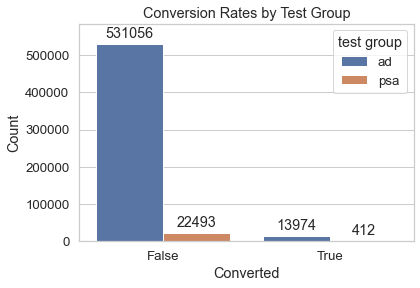

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style with larger grid
sns.set_style("whitegrid", {"grid.linewidth": 1.7})

# Generate count plot
ax = sns.countplot(x="converted", hue="test group", data=df)

# Get the counts for each bar
counts = df.groupby(["test group", "converted"]).size().reset_index(name="count")

# Add text to each bar
for i, container in enumerate(ax.containers):
    for j, count in enumerate(container):
        height = count.get_height()
        ax.annotate(counts.iloc[i*2+j]["count"], xy=(count.get_x() + count.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha="center", va="bottom")

# Set plot title and labels
ax.set_title("Conversion Rates by Test Group")
ax.set_xlabel("Converted")
ax.set_ylabel("Count")

# Set y-axis limit slightly larger than maximum count value
max_count = counts["count"].max()
ax.set_ylim(0, max_count + max_count*0.1)

plt.show()

In [51]:
from scipy.stats import ttest_ind
ttest_results = ttest_ind(df[df["test group"] == "ad"]["converted"], df[df["test group"] == "psa"]["converted"])
print(ttest_results)

Ttest_indResult(statistic=7.2201958039246, pvalue=5.197727369028733e-13)


The statistic value of 7.22 represents the t-statistic for the test. This value indicates that there is a significant difference between the means of the two groups being compared.

The pvalue value of 5.20e-13 represents the probability of observing a t-statistic at least as extreme as the observed value, assuming that there is no difference between the means of the two groups being compared (i.e., assuming the null hypothesis). This value is very small, which suggests strong evidence against the null hypothesis and in favor of the alternative hypothesis (i.e., that there is a significant difference between the means of the two groups).

Taken together, these results suggest that there is a significant difference between the means of the two groups being compared, and that this difference is unlikely to have occurred by chance alone.

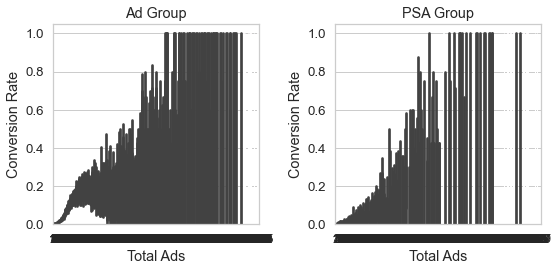

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

sns.barplot(x="total ads", y="converted", data=df[df["test group"] == "ad"], ax=ax[0])
ax[0].set(title="Ad Group", xlabel="Total Ads", ylabel="Conversion Rate")

sns.barplot(x="total ads", y="converted", data=df[df["test group"] == "psa"], ax=ax[1])
ax[1].set(title="PSA Group", xlabel="Total Ads", ylabel="Conversion Rate")

plt.tight_layout()
plt.show()

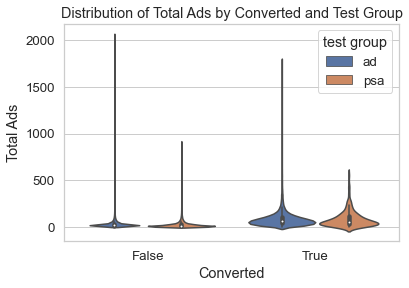

In [53]:
sns.violinplot(x="converted", y="total ads", hue="test group", data=df)
plt.title("Distribution of Total Ads by Converted and Test Group")
plt.xlabel("Converted")
plt.ylabel("Total Ads")
plt.show()

<AxesSubplot: xlabel='most ads hour', ylabel='converted'>

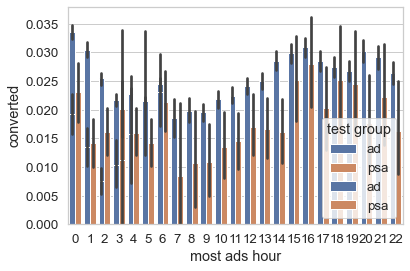

In [54]:
sns.barplot(x="most ads day", y="converted", hue="test group", data=df, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
sns.barplot(x="most ads hour", y="converted", hue="test group", data=df)

In [55]:
# Group the data by most ads hour, and calculate the mean of the converted column
conversion_by_hour = df.groupby("most ads hour")["converted"].mean()

# Find the hour with the highest conversion rate
max_conversion_hour = conversion_by_hour.idxmax()

# Print the result
print("The hour of the day with the highest conversion rate was:", max_conversion_hour)

The hour of the day with the highest conversion rate was: 16


So 4 pm in a day has the maximum business

In [56]:
# Calculate conversion rate by day and test group
conversion_by_day = df.groupby(["most ads day", "test group"])["converted"].mean()

# Reshape the data from long to wide format
conversion_by_day = conversion_by_day.unstack(level=1)

# Sort the values in descending order
conversion_by_day = conversion_by_day.sort_values(by=["ad", "psa"], ascending=False)

# Print the result
print(conversion_by_day)

test group       ad    psa
most ads day              
Monday       0.0335 0.0231
Tuesday      0.0304 0.0142
Wednesday    0.0255 0.0162
Sunday       0.0245 0.0213
Friday       0.0227 0.0159
Thursday     0.0217 0.0201
Saturday     0.0213 0.0141


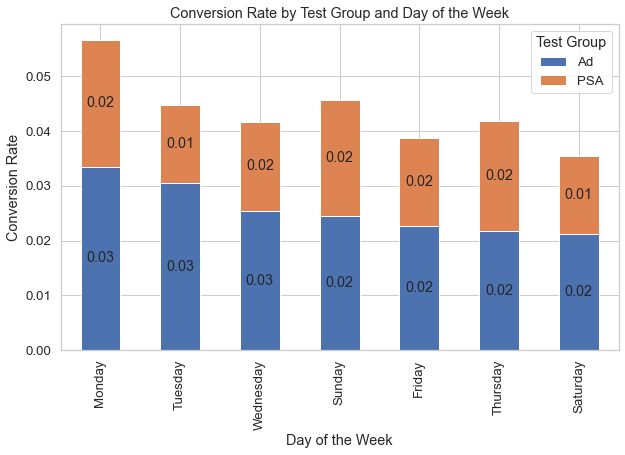

In [57]:
# Sort the values in descending order
conversion_by_day = conversion_by_day.sort_values(by=["ad", "psa"], ascending=False)

# Create a stacked bar plot of the conversion rate by day and test group
sns.set_style("whitegrid")
ax = conversion_by_day.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Conversion Rate by Test Group and Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Conversion Rate")

# Add value labels to each bar segment
for i in range(conversion_by_day.shape[0]):
    ad_value = conversion_by_day.iloc[i]["ad"]
    psa_value = conversion_by_day.iloc[i]["psa"]
    ax.text(i, ad_value / 2, f"{ad_value:.2f}", ha="center", va="center")
    ax.text(i, ad_value + psa_value / 2, f"{psa_value:.2f}", ha="center", va="center")

plt.legend(title="Test Group", labels=["Ad", "PSA"])
plt.show()

Monday is the maximum business day

In [58]:
# Group the data by most ads hour and calculate the mean of the converted column
conversion_by_hour = df.groupby("most ads hour")["converted"].mean()

# Sort the values in ascending order and take the top 10
top_10_less_business_hours = conversion_by_hour.sort_values().head(10)

# Print the result
print("Top 10 hours with less business:")
print(top_10_less_business_hours)

Top 10 hours with less business:
most ads hour
2    0.0073
3    0.0105
1    0.0129
4    0.0152
7    0.0181
0    0.0184
9    0.0192
8    0.0195
5    0.0209
10   0.0215
Name: converted, dtype: float64


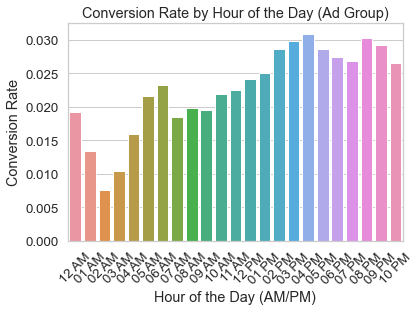

In [62]:
# Filter the data to include only the "ad" group
df_ad = df[df["test group"] == "ad"]

# Group the data by hour of the day, and calculate the mean of the converted column
conversion_by_hour = df_ad.groupby("most ads hour")["converted"].mean().reset_index()

# Create a new column for the hour in AM/PM format
conversion_by_hour["hour_ampm"] = pd.to_datetime(conversion_by_hour["most ads hour"], format="%H").dt.strftime("%I %p")

# Create a bar plot of the conversion rate by hour of the day
sns.barplot(data=conversion_by_hour, x="hour_ampm", y="converted")
plt.title("Conversion Rate by Hour of the Day (Ad Group)")
plt.xlabel("Hour of the Day (AM/PM)")
plt.ylabel("Conversion Rate")

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.show()

In [64]:
# Total Conversion rate 
totoal_cr = round(df['converted'].mean(),3)
print("The conversion rate for the two groups is {:.2f}%".format(totoal_cr   * 100))
# The probability converted in the treatment group
treatment_cr = round(df[(df['test group'] == 'ad') & (df['converted'] == 1)]['user id'].nunique() / df[df['test group'] == 'ad']['user id'].nunique(),3)
print("The conversion rate for the ad group is {:.2f}%".format(treatment_cr * 100))
# The probability converted in the control group
control_cr = round(df[(df['test group'] == 'psa') & (df['converted'] == 1)]['user id'].nunique() / df[df['test group'] == 'psa']['user id'].nunique(),3)
print("The conversion rate for the PSA group is {:.2f}%".format(control_cr  * 100))

print("The t-test p-value is {:.4f}".format(ttest_results.pvalue))

The conversion rate for the two groups is 2.50%
The conversion rate for the ad group is 2.60%
The conversion rate for the PSA group is 1.80%
The t-test p-value is 0.0000


The ad group had a higher conversion rate (2.55%) compared to the PSA group (1.79%). This indicates that the ad campaign was more effective in driving conversions compared to the PSA.

The t-test p-value of 0.0000 suggests that the difference in conversion rates between the two groups is statistically significant, meaning that it is unlikely to have occurred by chance alone. This strengthens our confidence in the observed difference between the two groups.

Overall, this suggests that the ad campaign was successful in driving conversions, and that the difference in conversion rates between the two groups is likely due to the impact of the ads.